## An Example Analysing NuSTAR Data

In this tutorial, we will go through the steps of analyzing NuSTAR observation of the AGN in center of `SWIFT J2127.4+5654` with `obsid = 60001110002` using `heasoftpy`.

The first thing we need is to import the `heasoftpy` package. 
>The first three lines are needed in case `heasoftpy` is not installed yet. We add the folder containing `heasoftpy` to `sys.path` so we can import it.

In [ ]:
import os
import sys

In [ ]:
# check the environment  #
if not 'HEADAS' in os.environ:
    raise RuntimeError('Heasoft is not initalized')
    
if not 'CALDB' in os.environ:
    raise RuntimeError('$CALDB is not defined. ')

try:
    sys.path.insert(0, os.path.abspath(os.path.join(os.path.abspath(''), '..')))
    import heasoftpy as hsp
except ImportError:
    raise RuntimeError('Please ensure heasoftpy is in your PYTHONPATH')

In [ ]:
print(hsp.__version__)
print(hsp.__path__)

Next, we want to download the data. If you have the data downloaded, you can move the observation folder to the same place as this notebook.

We can use either `wget` (linux) or `curl` (mac) to download the data

```bash
wget -q -nH -r -l0 -c -N -np -R 'index*' -erobots=off --retr-symlinks --cut-dirs=6 https://heasarc.gsfc.nasa.gov/FTP/nustar/data/obs/00/6//60001110002/
```

```bash
curl -s --remote-name https://heasarc.gsfc.nasa.gov/FTP/nustar/data/obs/00/6//60001110002/
```

In [ ]:

# downnload the data
obsid = '60001110002'
if not os.path.exists(obsid):
    os.system("wget -q -nH -r -l0 -c -N -np -R 'index*' -erobots=off --retr-symlinks --cut-dirs=6 "
              "https://heasarc.gsfc.nasa.gov/FTP/nustar/data/obs/00/6//60001110002/")


Next, we use `nupipeline` to process the data ([see detail here](https://heasarc.gsfc.nasa.gov/lheasoft/ftools/caldb/help/nupipeline.html)).

As we show in the [Getting Started](getting-started.ipynb) tutorial, we can either call `hsp.nupipeline` or create an instance of `hsp.HSPTaks`. Here, we use the latter

Note that to run `nupipeline`, only three parameters are needed: `indir`, `outdir` and `steminput`. By default, calling the task will also query for other parameters. We can instruct the task to use default values by setting `noprompt=True`.

Also, because `nupipeline` takes some time to run (several to tens of minutes), we will also request the output to printed on screen as the task runs by using `verbose=True`.

For the purposes of illustrations in this tutorial, we will focus on the `FMPA` instrument.

If we use `outdir='60001110002_p/event_cl'`, the call may look something like:


In [ ]:

# inialize the task instance
nupipeline = hsp.HSPTask('nupipeline')

# set some parameters.
outdir = obsid + '_p/event_cl'
stem   = 'nu' + obsid

# call the tasks
out = nupipeline(indir=obsid, outdir=outdir, steminputs=stem, instrument='FPMA', 
                 clobber='yes', noprompt=True, verbose=True)

After running for some time, and if things run smoothly, we will get a message like:

```
=============================================================================================
nupipeline_0.4.9: Exit with no errors - Fri Nov 26 13:53:29 EST 2021

=============================================================================================
=============================================================================================

```

A return code of `0`, indicates that the task run with success!

In [ ]:
print('return code:', out.returncode)

The main cleaned event files are: `nu60001110002A01_cl.evt` and `nu60001110002B01_cl.evt` for NuSTAR modules `A` and `B`, respectively.


---
Note that the same results can acheived by using the parameters as attributes of the tasks:

```python

nupipeline = hsp.HSPTask('nupipeline')

nupipeline.indir = obsid
nupipeline.outdir = obsid + '_p/event_cl'
nupipeline.steminput = 'nu' + obsid
nupipeline(noprompt=True, verbose=True)

```

---
### Extracting a light curve
Now that we have data processed, we can proceed and extract a light curve for the source. For this, we use `nuproducts` (see [nuproducts](https://heasarc.gsfc.nasa.gov/lheasoft/ftools/caldb/help/nuproducts.html) for details)

First, we need to create a source and background region files.

The source regions is a circle centered on the source with a radius of 150 arcseconds, while the background region is an annulus with an inner and outer radii of 180 and 300 arcseconds, respectively.

In [ ]:
# write region files
region = 'circle(21:27:46.406,+56:56:31.38,150")'
with open('src.reg', 'w') as fp: fp.write(region)

region = 'annulus(21:27:46.406,+56:56:31.38,180",300")'
with open('bgd.reg', 'w') as fp: fp.write(region)


In [ ]:

# initialize the task instance
nuproducts = hsp.HSPTask('nuproducts')

params = {
    'indir'         : f'{obsid}_p/event_cl',
    'outdir'        : f'{obsid}_p/lc',
    'instrument'    : 'FPMA',
    'steminputs'    : f'nu{obsid}',
    'outdir'        : f'{obsid}_p/lc',
    'binsize'       : 256,
    'bkgextract'    : 'yes',
    'srcregionfile' : 'src.reg',
    'bkgregionfile' : 'bgd.reg',
    'imagefile'     : 'none',
    'phafile'       : 'DEFAULT',
    'bkgphafile'    : 'DEFAULT',
    'runbackscale'  : 'yes',
    'correctlc'     : 'yes',
    'runmkarf'      : 'no',
    'runmkrmf'      : 'no',  
}

out = nuproducts(params, noprompt=True, verbose=True)


In [ ]:
print('return code:', out.returncode)

listing the content of the output directory `60001110002_p/lc`, we see that the task has created a source and background light cruves (`nu60001110002A01_sr.lc` and `nu60001110002A01_bk.lc`) along with the corresponding spectra. 

The task also generates `.flc` file, which contains the background-subtracted light curves.

We can proceed in different ways. We may for example use `fits` libraries in `astropy` to read this fits file directly, or we can use `ftlist` to dump the content of that file to an ascii file before reading it (we use `option=T` to list the table content).

In [ ]:
ftlist = hsp.HSPTask('ftlist')
out = ftlist(infile='60001110002_p/lc/nu60001110002A01.flc', option='T', 
             outfile='60001110002_p/lc/nu60001110002A01.txt', rownum='no', colheader='no', clobber='yes')

Again, we could also have used task attributes as input parameters:
```python

ftlist = hsp.HSPTask('ftlist')
ftlist.infile = '60001110002_p/lc/nu60001110002A01.flc'
ftlist.outfile = '60001110002_p/lc/nu60001110002A01.txt'
out = ftlist(option='T')

```

---

- Now, we use `numpy` for example for read the file, and `matplotlib` to plot it.

- For reading the data, we use `numpy.genfromtxt`, which allows for easy handling of missing data (`NULL` values in our case), so these are just replaced by `np.nan`

- The columns are: `Time`, `Time_err`, `Rate`, `Rate_err`, `Fraction_exposure`

- After reading the data, we plot the data points with full exposure (`Fraction_exposure == 1`)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
lc_data = np.genfromtxt('60001110002_p/lc/nu60001110002A01.txt', missing_values='NULL', filling_values=np.nan)
good_data = lc_data[:,4] == 1
lc_data = lc_data[good_data, :]

Text(0, 0.5, 'Count Rate (per sec)')

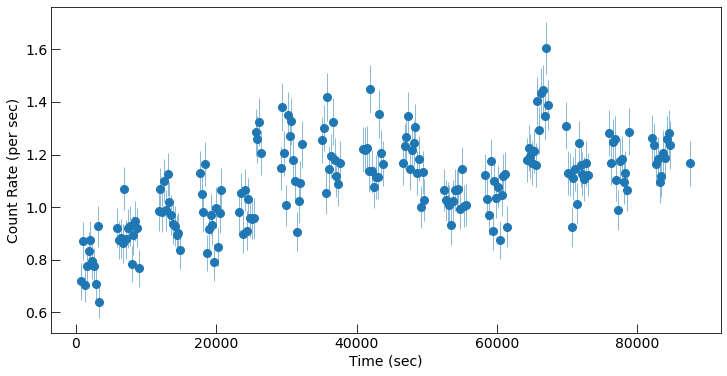

In [24]:
# modify the plot style a little bit
plt.rcParams.update({
    'font.size': 14, 
    'lines.markersize': 8.0,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 9.,
    'ytick.major.size': 9.,
})

fig = plt.figure(figsize=(12,6))
plt.errorbar(lc_data[:,0], lc_data[:,2], lc_data[:,3], fmt='o', lw=0.5)
plt.xlabel('Time (sec)')
plt.ylabel('Count Rate (per sec)')